In [1]:
!ls data

gender_submission.csv  test.csv  train.csv


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings

warnings.filterwarnings('ignore')

SEED = 42

## Loading the Dataset

- Training set has **891** rows and test set has **418** rows.
- Training set have **12** features and test set hava **11** features.
- One extra feature in the training set is `Survived` feature, which is the class of a row.

In [3]:
def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop([ 'Survived' ], axis=1)

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_all = pd.concat([ df_train, df_test ], sort=True).reset_index(drop=True)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'


dfs = [ df_train, df_test ]

print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')

print(f'Training X Shape = {df_train.shape}')
print(f'Training Y Shape = {df_train["Survived"].shape[0]}\n')

print(f'Test X Shape = {df_test.shape}')
print(f'Test Y Shape = {df_test.shape[0]}\n')

print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training Y Shape = 891

Test X Shape = (418, 11)
Test Y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## Exploratory Data Analysis

### Overview

- `PassengerId` feature is the unique id of the row and it doesn't have any effect on `Survived`.
- `Survived` feature is binary (**0** or **1**);
    - **1 = Survived**
    - **0 = Not Survived**
- `PClass` feature is the socio-economic status of the passenger. It is a categorical ordinal feature which has **3** unique values (**1**, **2** or **3**);
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
- `Name`, `Sex` and `Age` features are self-exploratory.
- `SibSp` feature is the total number of the passengers' siblings and spouse.
- `Parch` feature is the total number of the passengers' parents and children.
- `Ticket` feature is the ticket number of the passenger.
- `Fare` feature is the passenger fare.
- `Cabin` feature is the cabin number of the passenger.
- `Embarked` is port of embarkation. It is a categorical feature and it has **3** unique values (**C**, **Q** or **S**);
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Dealing with Missing Values

As seen from below, there are some columns with missing values. The `display_missing` function shows the count of missing values in each column in both training and test set.

- Training set have missing values in `Age`, `Cabin` and `Embarked` columns.
- Test set have missing values in `Age`, `Cabin` and `Fare` columns.

It is convenient to work on concatenated training and test set while dealing with missing values, otherwise the filled data may overfit to separate training or test sets. The amount of missing values in `Age`, `Embarked` and `Fare` features are relatively smaller compared to the total samples, but roughly **80%** of the `Cabin` feature is missing. Missing values in `Age`, `Embarked` and `Fare` features can be filled with descriptive statistical measures, but that wouldn't work for `Cabin`feature.

In [5]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print(df.name)
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




### Age

Missing values in `Age` feature are filled with de median age, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age os `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)** features, and it has only **3** unique values. It also makes more sense to group ages by passenges classes instead of other features.

In [6]:
options = {
    'kind': 'quicksort',
    'ascending': False
}

df_all_corr = df_all.corr().abs().unstack().sort_values(**options).reset_index().rename(columns={
    'level_0': 'Feature 1',
    'level_1': 'Feature 2',
    0: 'Correlation Coefficient',        
})

df_all_corr[ df_all_corr['Feature 1'] == 'Pclass' ][1:]

,Feature 1,Feature 2,Correlation Coefficient
8,Pclass,Fare,0.558629
10,Pclass,Age,0.408106
13,Pclass,Survived,0.338481
32,Pclass,SibSp,0.060832
35,Pclass,PassengerId,0.038354
43,Pclass,Parch,0.018322


In order to be more accurate, `Sex` feature is used as the second level of `groupby`. As seen from below, the `Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median `Age` compared to males. The median ages below are used for filling the missing values in `Age` feature.

In [7]:
age_by_pclass_sex = df_all.groupby([ 'Sex', 'Pclass' ]).median()['Age']

for pclass in range(1, 4):
    for sex in [ 'female', 'male' ]:
        print(f'Median age of Pclass {pclass} {sex}s: {age_by_pclass_sex[sex][pclass]}')
        
print(f'\nMedian age of all passengers: {df_all["Age"].median()}')

df_all['Age'] = df_all.groupby([ 'Sex', 'Pclass' ])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0

Median age of all passengers: 28.0


### Embarked

`Embarked` is a categorical feature and there are only **2** missing values in the whole dataset. Both of those passengers are female, upper class and they have the same ticket number. This means, they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [8]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### Fare

There is only one passenger with missing `Fare` value. We can assume that `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. Median `Fare` value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [10]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [11]:
med_fare = df_all.groupby([ 'Pclass', 'Parch', 'SibSp' ])['Fare'].median()[3][0][0]

df_all['Fare'] = df_all['Fare'].fillna(med_fare)

### Cabin

The `Cabin` feature is a little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.


![Titanic](assets/image.png)


- On the Boat Deck there were **6** rooms labeled as **T**, **U**, **W**, **X**, **Y**, **Z**, but only the **T** cabin is present in the dataset.
- **A**, **B** and **C** decks where only for 1st class passengers.
- **D** and **E** decks were for all classes.
- **F** and **G** decks were for both 2nd and 3rd class passengers.
- From going **A** to **G**, the distance to the staircase increases, which might be a factor of survival. If it is true, then the new `Deck`feature is ordinal.

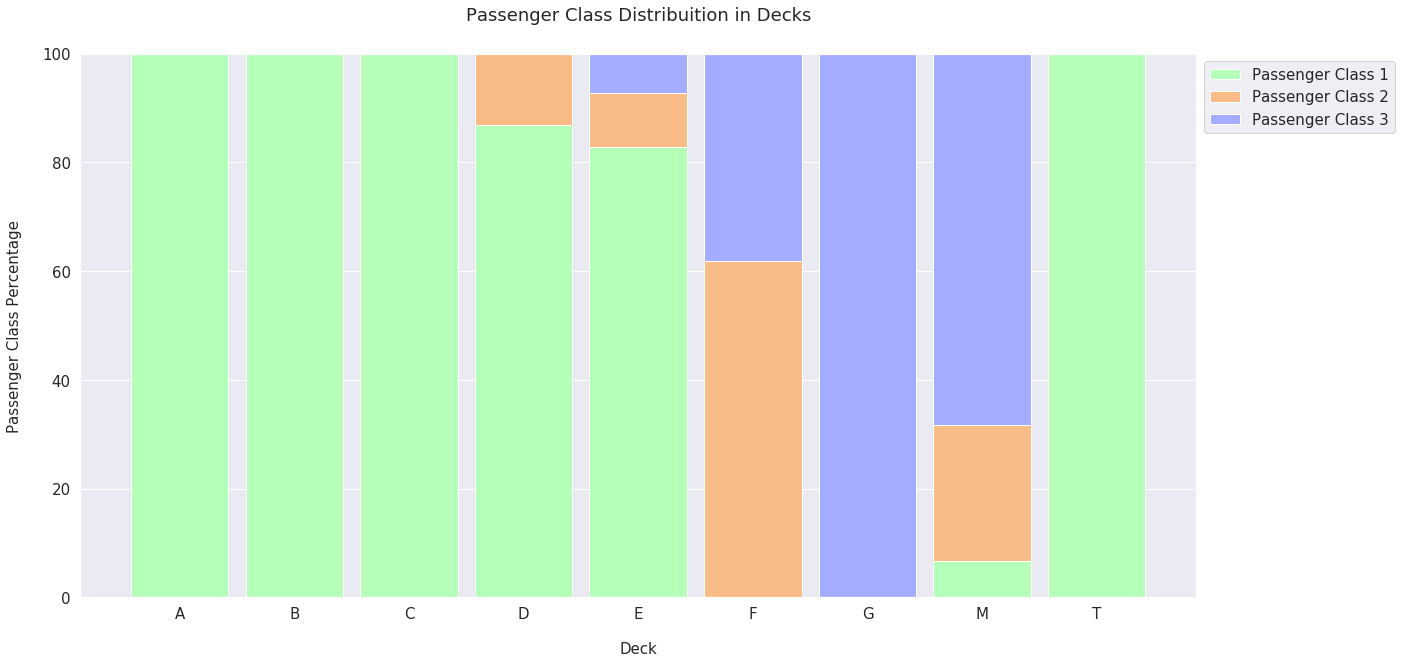

In [12]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

mapper = {
    'Name': 'Count'
}

df_all_decks = pd.DataFrame(df_all.groupby([ 'Deck', 'Pclass' ]).count()['Name'])
df_all_decks = df_all_decks.rename(columns=mapper).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {
        'A': {},
        'B': {},
        'C': {},
        'D': {},
        'E': {},
        'F': {},
        'G': {},
        'M': {},
        'T': {}
    }
    decks = df.columns.levels[0]
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                deck_counts[deck][pclass] = df[deck][pclass][0]
            except KeyError:
                deck_counts[deck][pclass] = 0
        
    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}
    
    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [
            (count / df_decks[col].sum()) * 100 for count in df_decks[col]
        ]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    
    options = {
        'x': bar_count,
        'height': [ 
            pclass1, 
            pclass2, 
            pclass3 
        ],
        'color': [ 
            '#b5ffb9',
            '#f9bc86',
            '#a3acff'
        ],
        'edgecolor': 'white',
        'width': bar_width,
        'label': 'Passenger Class '
    }
    
    for i in range(3):
        options = {
            'x': bar_count,
            'height': [ 
                pclass1, 
                pclass2, 
                pclass3 
            ][i],
            'bottom': [
                None,
                pclass1,
                pclass1 + pclass2
            ][i],
            'color': [ 
                '#b5ffb9',
                '#f9bc86',
                '#a3acff'
            ][i],
            'edgecolor': 'white',
            'width': bar_width,
            'label': f'Passenger Class {i+1}'
        }
        plt.bar(**options)
    
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    
    plt.xticks(bar_count, deck_names)
    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={ 'size': 15 })
    
    plt.title('Passenger Class Distribuition in Decks', size=18, y=1.05)
    
    plt.show()
    
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

- **100%** of **A**, **B** and **C** decks are 1st class passengers.
- Deck **D** has **87%** 1st class and **13%** 2nd class passengers.
- Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers.
- Deck **F** has **62%** 2nd class and **38%** 3rd class passengers.
- **100%** of **G** deck are 3rd class passengers.
- There is one person on the boat deck in the **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers, so he is grouped in **A** deck.
- Passengers labeled as **M** are the missing values in the `Cabin` feature. I don't think it is possible to find those passengers' real `Deck`. I decided to use **M** like a deck itself.

In [13]:
# Passenger in the T deck is changed to A
idx = df_all[ df_all['Deck'] == 'T' ].index
df_all.loc[idx, 'Deck'] = 'A'

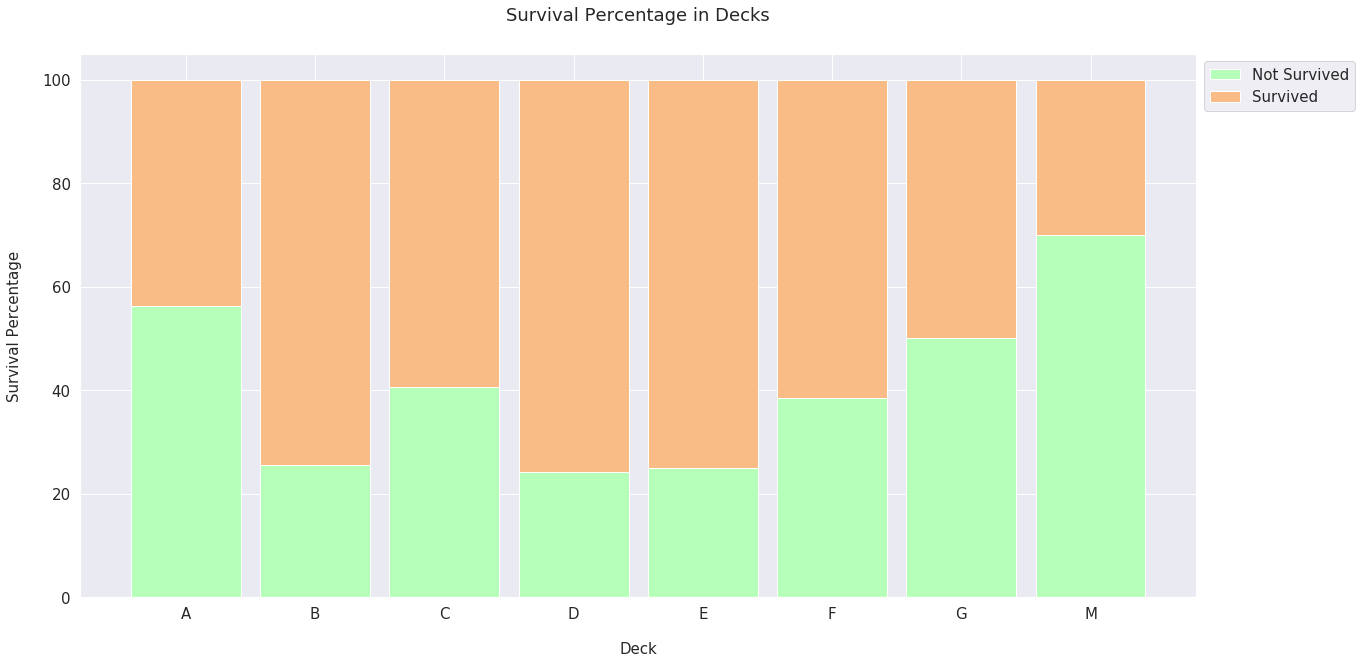

In [14]:
df_all_decks_survived = pd.DataFrame(df_all.groupby([ 'Deck', 'Survived' ]).count()['Name'])
df_all_decks_survived = df_all_decks_survived.rename(columns={ 'Name': 'Count' }).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {
        'A': {},
        'B': {},
        'C': {},
        'D': {},
        'E': {},
        'F': {},
        'G': {},
        'M': {}
    }
    decks = df.columns.levels[0]
    
    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
    
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}
    
    for col in df_surv.columns:
        surv_percentages[col] = [
            (count / df_surv[col].sum()) * 100 for count in df_surv[col]
        ]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85
    
    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    
    for i in range(2):
        options = {
            'x': bar_count,
            'height': [
                not_survived,
                survived
            ][i],
            'bottom': [
                None,
                not_survived
            ][i],
            'color': [
                '#b5ffb9',
                '#f9bc86'
            ][i],
            'edgecolor': 'white',
            'width': bar_width,
            'label': [
                'Not Survived',
                'Survived'
            ][i]
        }
        plt.bar(**options)
        
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    
    plt.xticks(bar_count, deck_names)
    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={ 'size': 15 })
    
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()
    
all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

As I suspected, every deck has differente survival rates and that information can't be discarded.  
Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe, labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with same characteristics. `Deck` feature has high-cardinality right now, so some of the values are grouped with each other depending on their resemblance.

- **A**, **B** and **C** decks labeled as **ABC** because all of them have only 1st class passengers.
- **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate.
- **F** and **G** decks are labeled as **FG** because of the previous reasons.
- **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [15]:
df_all['Deck'] = df_all['Deck'].replace([ 'A', 'B', 'C' ], 'ABC')
df_all['Deck'] = df_all['Deck'].replace([ 'D', 'E' ], 'DE')
df_all['Deck'] = df_all['Deck'].replace([ 'F', 'G' ], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [16]:
# Dropping the Cabin feature
df_all.drop([ 'Cabin' ], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [ df_train, df_test ]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




## Survival Distribution

- **38.38%** (342/891) of the training set is **Class 1**.
- **61.62%** (549/891) of the training set is **Class 2**.

342 of 891 passengers survived and it is the 38.38% of the training set
549 of 891 passengers didn't survived and it is the 61.62% of the training set


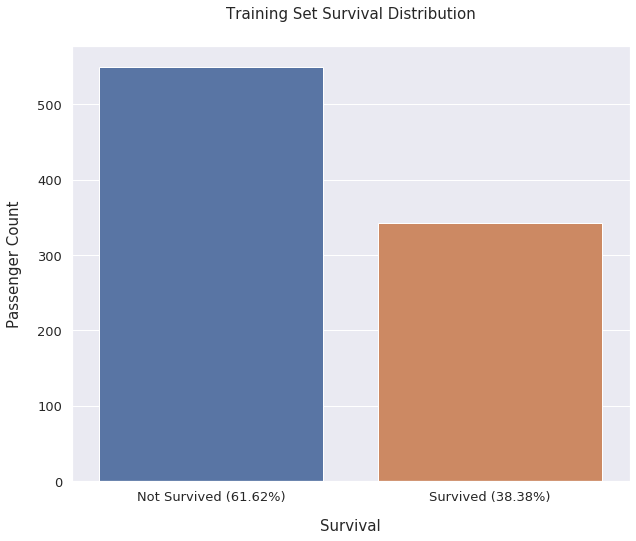

In [17]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = (survived / df_train.shape[0]) * 100
not_survived_per = (not_survived / df_train.shape[0]) * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set'.format(
    survived, df_train.shape[0], survived_per
))

print('{} of {} passengers didn\'t survived and it is the {:.2f}% of the training set'.format(
    not_survived, df_train.shape[0], not_survived_per
))

plt.figure(figsize=(10, 8))

sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)

ticks = (0, 1)
labels = [ 
    'Not Survived ({0:.2f}%)'.format(not_survived_per), 
    'Survived ({0:.2f}%)'.format(survived_per) 
]
plt.xticks(ticks, labels)

plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

## Correlations

- Features are highly correlated with each other and dependent to each other.
- The highest correlation between features is **0.549500** in training set and **0.577147** in test set (between `Fare` and `Pclass`).
- The other features are also highly correlated. There ate **9** correlations in training set and 6 correlations in test set that are higher than **0.1**.

In [22]:
df_train_corr = df_train.drop([ 'PassengerId' ], axis=1).corr().abs().unstack()
df_train_corr = df_train_corr.sort_values(kind='quicksort', ascending=False).reset_index()
df_train_corr = df_train_corr.rename(columns={
    'level_0': 'Feature 1',
    'level_1': 'Feature 2',
    0: 'Correlation Coefficient'
})
df_train_corr = df_train_corr.drop(df_train_corr[1::2].index)

df_test_corr = df_test.corr().abs().unstack()
df_test_corr = df_test_corr.sort_values(kind='quicksort', ascending=False).reset_index()
df_test_corr = df_test_corr.rename(columns={
    'level_0': 'Feature 1',
    'level_1': 'Feature 2',
    0: 'Correlation Coefficient'
})
df_test_corr = df_test_corr.drop(df_test_corr[1::2].index)


df_train_corr_nd = df_train_corr.drop(df_train_corr[ df_train_corr['Correlation Coefficient'] == 1.0 ].index)
df_test_corr_nd = df_test_corr.drop(df_test_corr[ df_test_corr['Correlation Coefficient'] == 1.0 ].index)

In [25]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [27]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


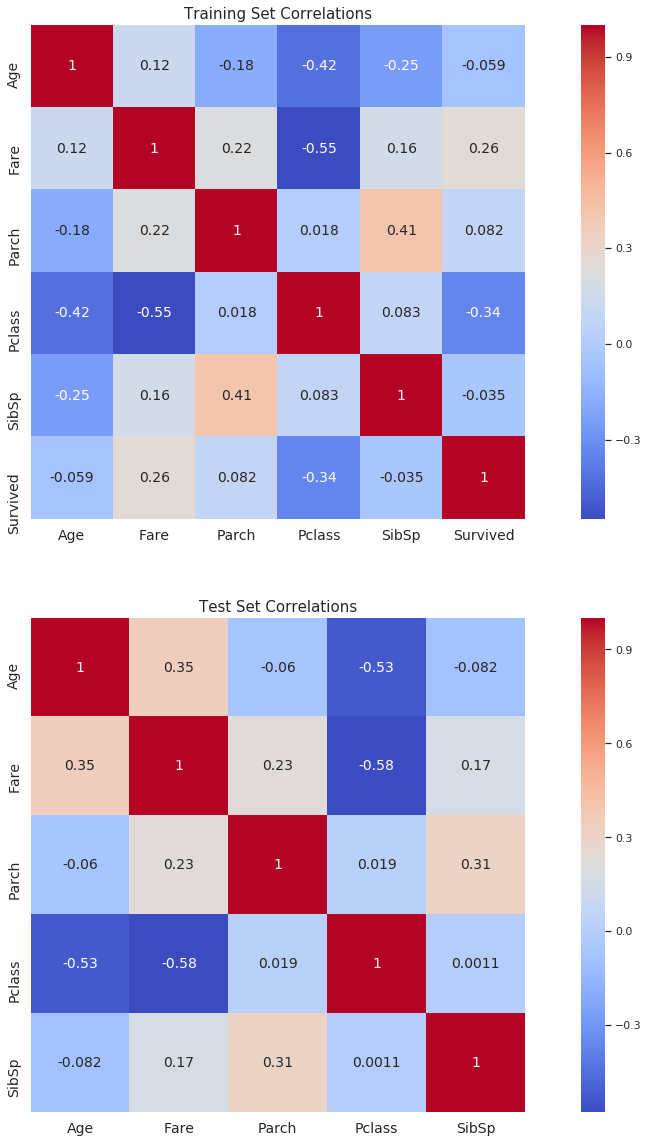

In [30]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

for i in range(2):
    sns.heatmap(
        data=[
            df_train.drop([ 'PassengerId' ], axis=1).corr(),
            df_test.drop([ 'PassengerId' ], axis=1).corr()
        ][i],
        ax=axs[i],
        annot=True,
        square=True,
        cmap='coolwarm',
        annot_kws={
            'size': 14
        }
    )

    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## Survival Distribution in Features

### Continuous Features

- Both of the continuous features, `Age` and `Fare`, have good split points and spikes for a decision tree algorithm to learn.
- Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups.
- In the distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extreme outliers.
